## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [33]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [34]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (15%)
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [35]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7484999895095825
epoch 2: valid acc = 0.7985000014305115
epoch 3: valid acc = 0.8195000290870667
epoch 4: valid acc = 0.8335000276565552
epoch 5: valid acc = 0.8450000286102295
epoch 6: valid acc = 0.8539999723434448
epoch 7: valid acc = 0.8569999933242798
epoch 8: valid acc = 0.8629999756813049
epoch 9: valid acc = 0.8654999732971191
epoch 10: valid acc = 0.8665000200271606
epoch 11: valid acc = 0.8700000047683716
epoch 12: valid acc = 0.8715000152587891
epoch 13: valid acc = 0.8759999871253967
epoch 14: valid acc = 0.8769999742507935
epoch 15: valid acc = 0.8759999871253967
test acc = 0.8598999977111816


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your 4-layer MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

In [36]:
# # Create you MLP using TensorFlow functions.
# classes = 20

# hidden_dim = [X_train.shape[1]] + [300, 200, 100] + [classes]
# layers_num = len(hidden_dim) - 1
# reg_tf = tf.constant(0.01)


# # define a tf.keras.Model class
# class Model(tf.keras.Model):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.W = {}
#         self.b = {}
#         for i in range(layers_num):
#           self.W[i] = tf.Variable(1e-2*np.random.rand(hidden_dim[i], hidden_dim[i+1]).astype('float32'))
#           self.b[i] = tf.Variable(np.zeros((hidden_dim[i+1],)).astype('float32'))

#     def call(self, inputs):
#         """Run the model."""
#         """feedforward"""
#         h = []
#         for i in range(layers_num-1):
#           h.append(tf.nn.relu(tf.matmul(inputs, self.W[i]) + self.b[i]))
#           inputs = h[i]
#         out = tf.matmul(inputs, self.W[i+1]) + self.b[i+1]
#         return out

# # Define and calculate loss function (Note that in eager execution, loss must be in a function)
# def loss(model, inputs, targets, reg = tf.constant(0.01)):
#     out = model(inputs)
#     cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
#     L2_loss = 0.0
#     for i in range(len(model.W)):
#       L2_loss += tf.nn.l2_loss(model.W[i])
#     return tf.reduce_mean(cross_entropy) + reg * L2_loss

# # calculate gradients for all variables using tf.GradientTape
# def grad(model, inputs, targets, params, reg = tf.constant(0.01)):
#     with tf.GradientTape() as tape:
#         loss_value = loss(model, inputs, targets, reg=reg)
#     return tape.gradient(loss_value, params)

# # calculate classification accuracy
# def eval_acc(model, inputs, targets):
#     correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     return accuracy

# num_train = 58000
# batch_size = 500
# num_batch = num_train//batch_size
# num_epochs = 15
# model = Model()
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# params = []
# for i in range(len(model.W)):
#   params.append(model.W[i])
#   params.append(model.b[i])

# for e in range(num_epochs):
#     for i in range(num_batch):
#         batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
#         x_tf = tf.Variable(batch_xs, dtype = tf.float32)
#         y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
#         grads = grad(model, x_tf, y_tf, params, reg_tf)
#         #optimization based on calculated gradients 
#         optimizer.apply_gradients(zip(grads, params))

#     x_tf = tf.Variable(X_val, dtype = tf.float32)
#     y_tf = tf.Variable(y_val, dtype = tf.uint8)
#     accuracy = eval_acc(model, x_tf, y_tf)
#     val_acc = accuracy.numpy()
#     print('epoch {}: valid acc = {}'.format(e+1, val_acc))

# x_tf = tf.Variable(X_test, dtype = tf.float32)
# y_tf = tf.Variable(y_test, dtype = tf.uint8)
# accuracy = eval_acc(model, x_tf, y_tf)
# test_acc = accuracy.numpy()
# print('test acc = {}'.format(test_acc))


## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32'))
        self.b3 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W4 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))                
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        h3 = tf.nn.relu(tf.matmul(h2, self.W3) + self.b3)
        out = tf.matmul(h3, self.W4) + self.b4
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3) + tf.nn.l2_loss(model.W4)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4]))


    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.15049999952316284
epoch 2: valid acc = 0.18199999630451202
epoch 3: valid acc = 0.24300000071525574
epoch 4: valid acc = 0.2290000021457672
epoch 5: valid acc = 0.23999999463558197
epoch 6: valid acc = 0.2134999930858612
epoch 7: valid acc = 0.1899999976158142
epoch 8: valid acc = 0.19750000536441803
epoch 9: valid acc = 0.2045000046491623
epoch 10: valid acc = 0.2485000044107437
epoch 11: valid acc = 0.2745000123977661
epoch 12: valid acc = 0.30399999022483826
epoch 13: valid acc = 0.3479999899864197
epoch 14: valid acc = 0.39149999618530273
epoch 15: valid acc = 0.3700000047683716
test acc = 0.3698999881744385


### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [37]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
D = X_train.shape[1]
num_class = y_train.max()+1

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_class)
])
# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
model.fit(
    x=X_train,
    y=y_train,
    batch_size=500,
    epochs=15,
    verbose=2,
    validation_data=(X_val, y_val),
    shuffle=True
)
model.summary()

# END of your code
#############################################################

Epoch 1/15
116/116 - 1s - loss: 14.2691 - sparse_categorical_accuracy: 0.7400 - val_loss: 6.7095 - val_sparse_categorical_accuracy: 0.7950
Epoch 2/15
116/116 - 0s - loss: 5.9828 - sparse_categorical_accuracy: 0.8057 - val_loss: 4.8947 - val_sparse_categorical_accuracy: 0.8115
Epoch 3/15
116/116 - 0s - loss: 4.4386 - sparse_categorical_accuracy: 0.8203 - val_loss: 3.9319 - val_sparse_categorical_accuracy: 0.8120
Epoch 4/15
116/116 - 0s - loss: 3.4546 - sparse_categorical_accuracy: 0.8328 - val_loss: 3.2795 - val_sparse_categorical_accuracy: 0.8275
Epoch 5/15
116/116 - 0s - loss: 2.8375 - sparse_categorical_accuracy: 0.8415 - val_loss: 3.0232 - val_sparse_categorical_accuracy: 0.8250
Epoch 6/15
116/116 - 0s - loss: 2.4118 - sparse_categorical_accuracy: 0.8473 - val_loss: 2.6106 - val_sparse_categorical_accuracy: 0.8330
Epoch 7/15
116/116 - 0s - loss: 2.0748 - sparse_categorical_accuracy: 0.8530 - val_loss: 2.5411 - val_sparse_categorical_accuracy: 0.8310
Epoch 8/15
116/116 - 0s - loss: 1

## Part 2: t-SNE (5%)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [38]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [39]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [40]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))

2.844723387497046
The 100 th loop cost: 12.042525362700166, computation time: 1.5689382553100586
The 200 th loop cost: 0.579026904082659, computation time: 3.134408473968506
The 300 th loop cost: 0.5412033311121657, computation time: 4.716006755828857
The 400 th loop cost: 0.5341556196092928, computation time: 6.270210027694702
The 500 th loop cost: 0.5323997722668532, computation time: 7.8313212394714355
The 600 th loop cost: 0.5316685468619667, computation time: 9.383899211883545
The 700 th loop cost: 0.5312922238708806, computation time: 10.939179182052612
The 800 th loop cost: 0.5310744997222671, computation time: 12.511173486709595
The 900 th loop cost: 0.5309384574298783, computation time: 14.08798861503601
The 1000 th loop cost: 0.5308494239479988, computation time: 15.699678659439087
it takes 16.342384099960327 seconds


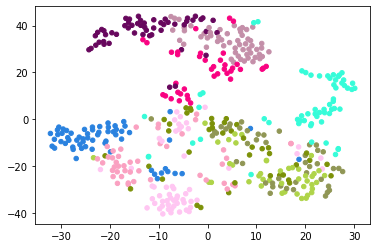

In [41]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [42]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.8125, new learning rate = 0.00095
epoch 2: valid acc = 0.846, new learning rate = 0.0009025
epoch 3: valid acc = 0.848, new learning rate = 0.000857375
epoch 4: valid acc = 0.8585, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.868, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.864, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.8795, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.877, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.8805, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8815, new learning rate = 0.0005987369392383785
test acc: 0.8682


0.8682

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [43]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   #
# apply softmax to obtain output of the MLP model.                          #
#############################################################################
Y = tsne(X, low_dim=2, perplexity=25.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

725.4045290356213
The 100 th loop cost: 12.033871452855061, computation time: 1.580702304840088
The 200 th loop cost: 0.579110583795825, computation time: 3.156498432159424
The 300 th loop cost: 0.5405487242749869, computation time: 4.715362071990967
The 400 th loop cost: 0.5333726850069356, computation time: 6.281051874160767
The 500 th loop cost: 0.5315951252497723, computation time: 7.856649398803711
The 600 th loop cost: 0.5308542169271832, computation time: 9.450474262237549
The 700 th loop cost: 0.5304781179079161, computation time: 11.039684057235718
The 800 th loop cost: 0.5302607783399793, computation time: 12.632992506027222
The 900 th loop cost: 0.5301264934701296, computation time: 14.214521408081055
The 1000 th loop cost: 0.5300389738907121, computation time: 15.806317329406738
it takes 16.86869239807129 seconds


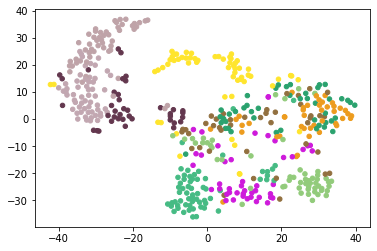

In [44]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data                             #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [45]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]


#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
Y = tsne(X, low_dim=2, perplexity=100)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

1061.998043067723
The 100 th loop cost: 10.010783264101555, computation time: 1.618192434310913
The 200 th loop cost: 0.2824439308413388, computation time: 3.281096935272217
The 300 th loop cost: 0.2809546054154295, computation time: 4.913200616836548
The 400 th loop cost: 0.28091770313525855, computation time: 6.520961046218872
The 500 th loop cost: 0.2809177031060706, computation time: 8.141806602478027
The 600 th loop cost: 0.28091770310607034, computation time: 9.75175142288208
The 700 th loop cost: 0.2809177031060703, computation time: 11.328136205673218
The 800 th loop cost: 0.28091770310607045, computation time: 12.912410974502563
The 900 th loop cost: 0.28091770310607034, computation time: 14.515014410018921
The 1000 th loop cost: 0.2809177031060703, computation time: 16.118587255477905
it takes 34.321274757385254 seconds


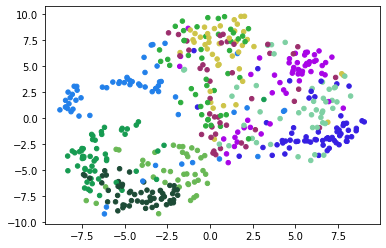

In [46]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################